<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/5.%20Modelling/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn imports for machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import KNNImputer
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Other Libraries
from scipy.stats import mstats
import copy
import tqdm

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 240)

# Plotting Function
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 2.5))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="Blues")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

# Scorer Functions
def sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    return sensitivity

def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    return specificity

def auroc_scorer(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def aucpr_scorer(y_true, y_pred):
    return average_precision_score(y_true, y_pred)

sensitivity_scorer = make_scorer(sensitivity)
specificity_scorer = make_scorer(specificity)
auroc_scorer = make_scorer(auroc_scorer)
aucpr_scorer = make_scorer(aucpr_scorer)

# Winsorization Class
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, lower=0.01, upper=0.99):
        self.columns = columns
        self.lower = lower
        self.upper = upper

    def fit(self, X, y=None):
        # Keine spezielle Anpassung erforderlich
        return self

    def transform(self, X):
        if self.columns is None:
            columns = X.columns
        else:
            columns = self.columns

        X_copy = X.copy()
        for col in columns:
            X_copy[col] = mstats.winsorize(X_copy[col], limits=[self.lower, self.upper])

        return X_copy

In [34]:
# !wget 'https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/clean_data.csv' -O clean_data.csv

data = pd.read_csv('modelling_data.csv')
data.shape

FileNotFoundError: [Errno 2] No such file or directory: 'modelling_data.csv'

In [30]:
# Defining Feature Sets
'''
extreme_outlier = [
    "BMI",
    "Body_Temperature"
]
'''

restricted = [
    "Length_of_Stay",
    "Appendix_on_US",
    "Alvarado_Score",
    "Paedriatic_Appendicitis_Score",
    "Segmented_Neutrophils"
]


partially_restricted = [
    "Length_of_Stay",
    "Neutrophilia",
    "CRP",
    "Alvarado_Score",
    "Ketones_in_Urine",
    "WBC_in_Urine",
    "RBC_in_Urine",
    "Paedriatic_Appendicitis_Score"
]

unrestricted = [
    'Appendix_Diameter', 
    'Length_of_Stay', 
    'Surrounding_Tissue_Reaction', 
    'Alvarado_Score', 
    'Neutrophil_Percentage',
    'Appendix_on_US',
    'CRP',
    'Peritonitis',
    'WBC_Count'
]

complete = ['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US', 'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'Segmented_Neutrophils', 'Neutrophilia', 'RBC_Count', 'Hemoglobin', 'RDW',
       'Thrombocyte_Count', 'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria', 'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign',
       'Appendicolith', 'Perfusion', 'Perforation', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess', 'Pathological_Lymph_Nodes', 'Bowel_Wall_Thickening', 'Conglomerate_of_Bowel_Loops', 'Ileus', 'Coprostasis', 'Meteorism',
       'Enteritis', 'Gynecological_Findings']

TARGET = "Diagnosis"

sets = [restricted, partially_restricted, unrestricted, complete]
set_names = [
    "Restricted Dataset: Subset of Demographic + Scoring + Clinical",
    "Partially Restricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory",
    "Unrestricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory + Ultrasound",
    "Complete Dataset: all variables"
            ]

## Logistic Regression

C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1006: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 141, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: auroc_scorer() takes 2 positional arguments but 3 were given

  warnings.warn(
C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1006: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 141, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            

Restricted Dataset: Subset of Demographic + Scoring + Clinical
Accuracy: 	 0.817 (± 0.04 )
ROC: 	 	 nan (± nan )
AUCPR: 	 	 nan (± nan )
Sensitivy: 	 0.857 (± 0.07 )
Specificity: 	 0.760 (± 0.00 )
 


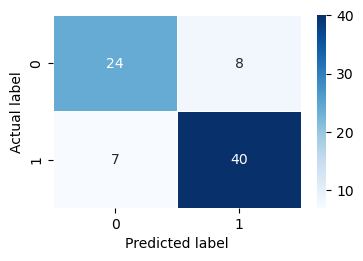

C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1006: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 141, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: auroc_scorer() takes 2 positional arguments but 3 were given

  warnings.warn(
C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1006: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 141, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            

Partially Restricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory
Accuracy: 	 0.741 (± 0.03 )
ROC: 	 	 nan (± nan )
AUCPR: 	 	 nan (± nan )
Sensitivy: 	 0.774 (± 0.04 )
Specificity: 	 0.690 (± 0.00 )
 


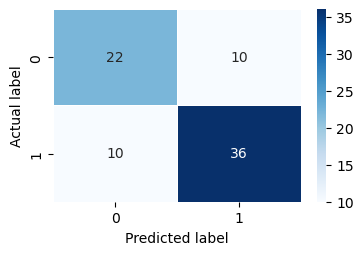

C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1006: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 141, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: auroc_scorer() takes 2 positional arguments but 3 were given

  warnings.warn(
C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1006: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 141, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            

C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1006: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 141, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: aucpr_scorer() takes 2 positional arguments but 3 were given

  warnings.warn(


Unrestricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory + Ultrasound
Accuracy: 	 0.905 (± 0.03 )
ROC: 	 	 nan (± nan )
AUCPR: 	 	 nan (± nan )
Sensitivy: 	 0.912 (± 0.03 )
Specificity: 	 0.893 (± 0.00 )
 


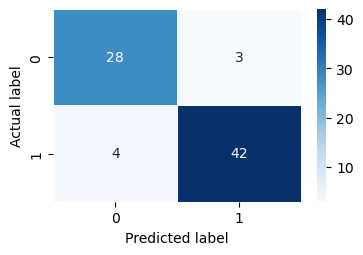

C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1006: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 141, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: auroc_scorer() takes 2 positional arguments but 3 were given

  warnings.warn(
C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1006: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 141, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            

C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1006: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 141, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: aucpr_scorer() takes 2 positional arguments but 3 were given

  warnings.warn(
C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1006: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mariu\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 141, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            

Complete Dataset: all variables
Accuracy: 	 0.894 (± 0.03 )
ROC: 	 	 nan (± nan )
AUCPR: 	 	 nan (± nan )
Sensitivy: 	 0.901 (± 0.04 )
Specificity: 	 0.879 (± 0.00 )
 


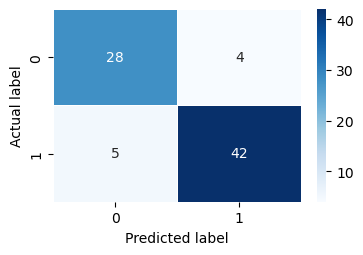

In [32]:
lr_accuracy = []
lr_auroc = []
lr_aucpr = []
lr_sensitivity = []
lr_specificity = []

lr_accuracy_sd = []
lr_auroc_sd = []
lr_aucpr_sd = []
lr_sensitivity_sd = []
lr_specificity_sd = []


for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    
    subset = set_names[index]
    
    # Model & pipeline
    lr_model = LogisticRegression(max_iter=1000, random_state=123)

    lr_pipeline = Pipeline([
        # ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=5)),
        ('classifier', lr_model)
    ])

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

    # Calculate Scores
    # Confusion Matrix
    y_pred_cv = cross_val_predict(lr_pipeline, X, y, cv=k_fold)
    cm_lr = confusion_matrix(y, y_pred_cv)
    cm_lr = cm_lr / splits
    cm_lr = np.round(cm_lr,0)
    cm_lr = cm_lr.astype(int)
    confusion_matrices.append(cm_lr)

    # Accuracy
    cv_scores_accuracy = cross_val_score(lr_pipeline, X, y, cv=k_fold, scoring="accuracy")
    mean_cv_accuracy = cv_scores_accuracy.mean()
    sd_cv_accuracy = cv_scores_accuracy.std()
    lr_accuracy.append(mean_cv_accuracy)
    lr_accuracy_sd.append(sd_cv_accuracy)

    # ROC
    cv_scores_auroc = cross_val_score(lr_pipeline, X, y, cv=k_fold, scoring=auroc_scorer)
    mean_cv_auroc = cv_scores_auroc.mean()
    sd_cv_auroc = cv_scores_auroc.std()
    lr_auroc.append(mean_cv_auroc)
    lr_auroc_sd.append(sd_cv_auroc)

    # AUCPR
    cv_scores_aucpr = cross_val_score(lr_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer)
    mean_cv_aucpr = cv_scores_aucpr.mean()
    sd_cv_aucpr = cv_scores_aucpr.std()
    lr_aucpr.append(mean_cv_aucpr)
    lr_aucpr_sd.append(sd_cv_aucpr)

    # Sensitivy
    cv_scores_sensitivity = cross_val_score(lr_pipeline, X, y, cv=k_fold, scoring="recall")
    mean_cv_sensitivity = cv_scores_sensitivity.mean()
    sd_cv_sensitivity = cv_scores_sensitivity.std()
    lr_sensitivity.append(mean_cv_sensitivity)
    lr_sensitivity_sd.append(sd_cv_sensitivity)

    # Specificity
    cv_scores_specificity = cross_val_score(lr_pipeline, X, y, cv=k_fold, scoring=specificity_scorer)
    mean_cv_specificity = cv_scores_specificity.mean()
    sd_cv_specificity = mean_cv_specificity.std()
    lr_specificity.append(mean_cv_specificity)
    lr_specificity_sd.append(sd_cv_specificity)

    print("\033[1m" + subset + "\033[0m")
    print("Accuracy: \t", "{:.3f}".format(round(mean_cv_accuracy,3)), "(±", "{:.2f}".format(round(sd_cv_accuracy, 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(mean_cv_auroc,3)), "(±", "{:.2f}".format(round(sd_cv_auroc, 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(mean_cv_aucpr,3)), "(±", "{:.2f}".format(round(sd_cv_aucpr, 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(mean_cv_sensitivity,3)), "(±", "{:.2f}".format(round(sd_cv_sensitivity, 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(mean_cv_specificity, 3)), "(±", "{:.2f}".format(round(sd_cv_specificity, 2)), ")")
    print(" ")
    plot_confusion_matrix(cm_lr, "")

## Naive Bayes Classifier

Restricted Dataset: Demographic + Scoring + Clinical
Accuracy: 	 0.794 (± 0.04 )
ROC: 	 	 0.793 (± 0.04 )
AUCPR: 	 	 0.797 (± 0.04 )
Sensitivy: 	 0.795 (± 0.05 )
Specificity: 	 0.792 (± 0.00 )
 


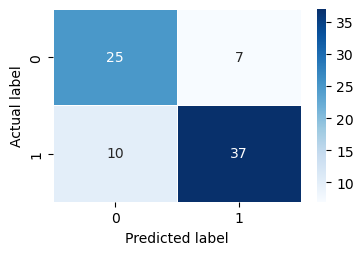

Partially Restricted Dataset: Demographic + Scoring + Clinical + Laboratory
Accuracy: 	 0.714 (± 0.04 )
ROC: 	 	 0.728 (± 0.04 )
AUCPR: 	 	 0.750 (± 0.03 )
Sensitivy: 	 0.648 (± 0.07 )
Specificity: 	 0.808 (± 0.00 )
 


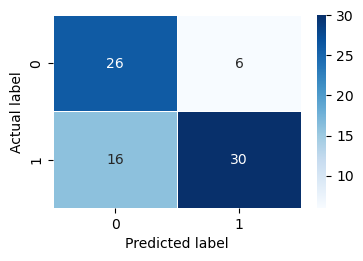

Unrestricted Dataset: Demographic + Scoring + Clinical + Laboratory + Ultrasound
Accuracy: 	 0.827 (± 0.05 )
ROC: 	 	 0.836 (± 0.05 )
AUCPR: 	 	 0.847 (± 0.05 )
Sensitivy: 	 0.785 (± 0.05 )
Specificity: 	 0.887 (± 0.00 )
 


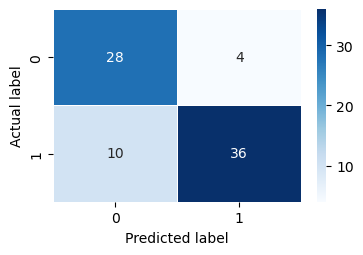

Complete Dataset: all variables
Accuracy: 	 0.659 (± 0.04 )
ROC: 	 	 0.707 (± 0.03 )
AUCPR: 	 	 0.755 (± 0.04 )
Sensitivy: 	 0.444 (± 0.08 )
Specificity: 	 0.971 (± 0.00 )
 


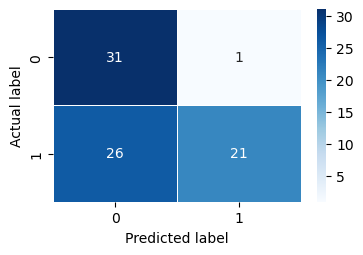

In [21]:
nb_accuracy = []
nb_auroc = []
nb_aucpr = []
nb_sensitivity = []
nb_specificity = []

nb_accuracy_sd = []
nb_auroc_sd = []
nb_aucpr_sd = []
nb_sensitivity_sd = []
nb_specificity_sd = []

for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    
    subset = set_names[index]

    # Model & pipeline
    nb_model = GaussianNB()

    nb_pipeline = Pipeline([
        # ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=5)),
        ('classifier', nb_model)
    ])

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

    # Calculate Scores
    # Confusion Matrix
    y_pred_cv = cross_val_predict(nb_pipeline, X, y, cv=k_fold)
    cm_nb = confusion_matrix(y, y_pred_cv)
    cm_nb = cm_nb / splits
    cm_nb = np.round(cm_nb,0)
    cm_nb = cm_nb.astype(int)
    confusion_matrices.append(cm_nb)

    # Accuracy
    cv_scores_accuracy = cross_val_score(nb_pipeline, X, y, cv=k_fold, scoring="accuracy")
    mean_cv_accuracy = cv_scores_accuracy.mean()
    sd_cv_accuracy = cv_scores_accuracy.std()
    nb_accuracy.append(mean_cv_accuracy)
    nb_accuracy_sd.append(sd_cv_accuracy)

    # ROC
    cv_scores_auroc = cross_val_score(nb_pipeline, X, y, cv=k_fold, scoring=auroc_scorer)
    mean_cv_auroc = cv_scores_auroc.mean()
    sd_cv_auroc = cv_scores_auroc.std()
    nb_auroc.append(mean_cv_auroc)
    nb_auroc_sd.append(sd_cv_auroc)

    # AUCPR
    cv_scores_aucpr = cross_val_score(nb_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer)
    mean_cv_aucpr = cv_scores_aucpr.mean()
    sd_cv_aucpr = cv_scores_aucpr.std()
    nb_aucpr.append(mean_cv_aucpr)
    nb_aucpr_sd.append(sd_cv_aucpr)

    # Sensitivy
    cv_scores_sensitivity = cross_val_score(nb_pipeline, X, y, cv=k_fold, scoring="recall")
    mean_cv_sensitivity = cv_scores_sensitivity.mean()
    sd_cv_sensitivity = cv_scores_sensitivity.std()
    nb_sensitivity.append(mean_cv_sensitivity)
    nb_sensitivity_sd.append(sd_cv_sensitivity)

    # Specificity
    cv_scores_specificity = cross_val_score(nb_pipeline, X, y, cv=k_fold, scoring=specificity_scorer)
    mean_cv_specificity = cv_scores_specificity.mean()
    sd_cv_specificity = mean_cv_specificity.std()
    nb_specificity.append(mean_cv_specificity)
    nb_specificity_sd.append(sd_cv_specificity)

    print("\033[1m" + subset + "\033[0m")
    print("Accuracy: \t", "{:.3f}".format(round(mean_cv_accuracy,3)), "(±", "{:.2f}".format(round(sd_cv_accuracy, 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(mean_cv_auroc,3)), "(±", "{:.2f}".format(round(sd_cv_auroc, 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(mean_cv_aucpr,3)), "(±", "{:.2f}".format(round(sd_cv_aucpr, 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(mean_cv_sensitivity,3)), "(±", "{:.2f}".format(round(sd_cv_sensitivity, 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(mean_cv_specificity, 3)), "(±", "{:.2f}".format(round(sd_cv_specificity, 2)), ")")
    print(" ")
    plot_confusion_matrix(cm_nb, "")

## Support Vector Machine

Restricted Dataset: Demographic + Scoring + Clinical
Accuracy: 	 0.837 (± 0.02 )
ROC: 	 	 0.820 (± 0.02 )
AUCPR: 	 	 0.809 (± 0.03 )
Sensitivy: 	 0.917 (± 0.03 )
Specificity: 	 0.722 (± 0.00 )
 


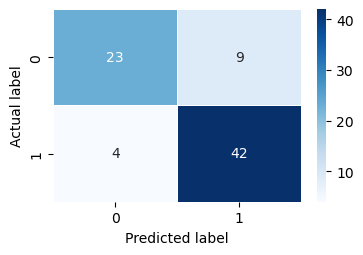

Partially Restricted Dataset: Demographic + Scoring + Clinical + Laboratory
Accuracy: 	 0.723 (± 0.03 )
ROC: 	 	 0.719 (± 0.03 )
AUCPR: 	 	 0.734 (± 0.02 )
Sensitivy: 	 0.740 (± 0.04 )
Specificity: 	 0.699 (± 0.00 )
 


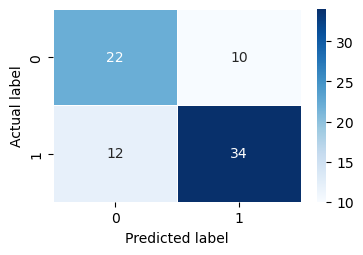

Unrestricted Dataset: Demographic + Scoring + Clinical + Laboratory + Ultrasound
Accuracy: 	 0.917 (± 0.03 )
ROC: 	 	 0.917 (± 0.03 )
AUCPR: 	 	 0.918 (± 0.03 )
Sensitivy: 	 0.913 (± 0.04 )
Specificity: 	 0.922 (± 0.00 )
 


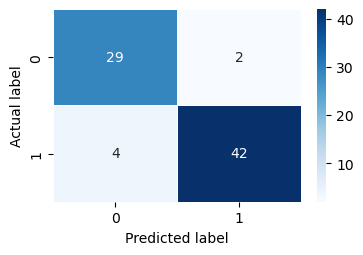

Complete Dataset: all variables
Accuracy: 	 0.872 (± 0.04 )
ROC: 	 	 0.870 (± 0.04 )
AUCPR: 	 	 0.868 (± 0.03 )
Sensitivy: 	 0.878 (± 0.04 )
Specificity: 	 0.862 (± 0.00 )
 


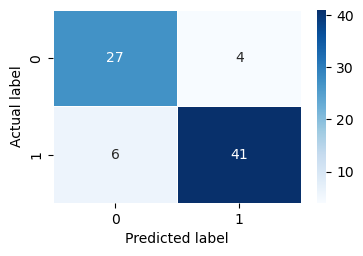

In [23]:
svm_accuracy = []
svm_auroc = []
svm_aucpr = []
svm_sensitivity = []
svm_specificity = []

svm_accuracy_sd = []
svm_auroc_sd = []
svm_aucpr_sd = []
svm_sensitivity_sd = []
svm_specificity_sd = []

for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    
    subset = set_names[index]

    # Model & pipeline
    svm_model = SVC(kernel='rbf', random_state=123, probability=True)

    svm_pipeline = Pipeline([
        # ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=5)),
        ('classifier', svm_model)
    ])

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

    # Calculate Scores
    # Confusion Matrix
    y_pred_cv = cross_val_predict(svm_pipeline, X, y, cv=k_fold)
    cm_svm = confusion_matrix(y, y_pred_cv)
    cm_svm = cm_svm / splits
    cm_svm = np.round(cm_svm,0)
    cm_svm = cm_svm.astype(int)
    confusion_matrices.append(cm_svm)

    # Accuracy
    cv_scores_accuracy = cross_val_score(svm_pipeline, X, y, cv=k_fold, scoring="accuracy")
    mean_cv_accuracy = cv_scores_accuracy.mean()
    sd_cv_accuracy = cv_scores_accuracy.std()
    svm_accuracy.append(mean_cv_accuracy)
    svm_accuracy_sd.append(sd_cv_accuracy)

    # ROC
    cv_scores_auroc = cross_val_score(svm_pipeline, X, y, cv=k_fold, scoring=auroc_scorer)
    mean_cv_auroc = cv_scores_auroc.mean()
    sd_cv_auroc = cv_scores_auroc.std()
    svm_auroc.append(mean_cv_auroc)
    svm_auroc_sd.append(sd_cv_auroc)

    # AUCPR
    cv_scores_aucpr = cross_val_score(svm_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer)
    mean_cv_aucpr = cv_scores_aucpr.mean()
    sd_cv_aucpr = cv_scores_aucpr.std()
    svm_aucpr.append(mean_cv_aucpr)
    svm_aucpr_sd.append(sd_cv_aucpr)

    # Sensitivy
    cv_scores_sensitivity = cross_val_score(svm_pipeline, X, y, cv=k_fold, scoring="recall")
    mean_cv_sensitivity = cv_scores_sensitivity.mean()
    sd_cv_sensitivity = cv_scores_sensitivity.std()
    svm_sensitivity.append(mean_cv_sensitivity)
    svm_sensitivity_sd.append(sd_cv_sensitivity)

    # Specificity
    cv_scores_specificity = cross_val_score(svm_pipeline, X, y, cv=k_fold, scoring=specificity_scorer)
    mean_cv_specificity = cv_scores_specificity.mean()
    sd_cv_specificity = mean_cv_specificity.std()
    svm_specificity.append(mean_cv_specificity)
    svm_specificity_sd.append(sd_cv_specificity)

    print("\033[1m" + subset + "\033[0m")
    print("Accuracy: \t", "{:.3f}".format(round(mean_cv_accuracy,3)), "(±", "{:.2f}".format(round(sd_cv_accuracy, 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(mean_cv_auroc,3)), "(±", "{:.2f}".format(round(sd_cv_auroc, 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(mean_cv_aucpr,3)), "(±", "{:.2f}".format(round(sd_cv_aucpr, 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(mean_cv_sensitivity,3)), "(±", "{:.2f}".format(round(sd_cv_sensitivity, 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(mean_cv_specificity, 3)), "(±", "{:.2f}".format(round(sd_cv_specificity, 2)), ")")
    print(" ")
    plot_confusion_matrix(cm_svm, "")

## Random Forest Classifier

Restricted Dataset: Demographic + Scoring + Clinical
Accuracy: 	 0.821 (± 0.05 )
ROC: 	 	 0.802 (± 0.05 )
AUCPR: 	 	 0.795 (± 0.04 )
Sensitivy: 	 0.901 (± 0.06 )
Specificity: 	 0.702 (± 0.00 )
 


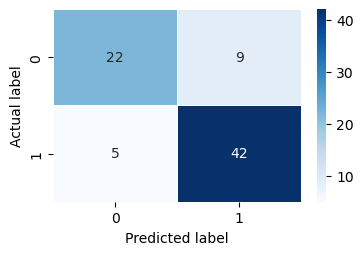

Partially Restricted Dataset: Demographic + Scoring + Clinical + Laboratory
Accuracy: 	 0.724 (± 0.04 )
ROC: 	 	 0.710 (± 0.05 )
AUCPR: 	 	 0.727 (± 0.03 )
Sensitivy: 	 0.776 (± 0.07 )
Specificity: 	 0.644 (± 0.00 )
 


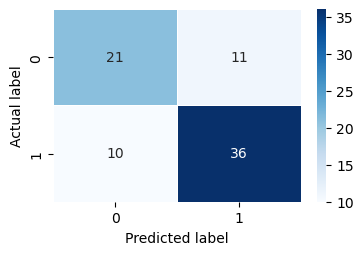

Unrestricted Dataset: Demographic + Scoring + Clinical + Laboratory + Ultrasound
Accuracy: 	 0.946 (± 0.03 )
ROC: 	 	 0.943 (± 0.04 )
AUCPR: 	 	 0.942 (± 0.03 )
Sensitivy: 	 0.954 (± 0.02 )
Specificity: 	 0.933 (± 0.00 )
 


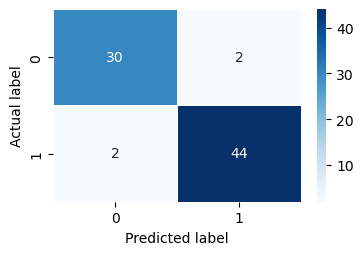

Complete Dataset: all variables
Accuracy: 	 0.944 (± 0.04 )
ROC: 	 	 0.941 (± 0.04 )
AUCPR: 	 	 0.941 (± 0.04 )
Sensitivy: 	 0.949 (± 0.03 )
Specificity: 	 0.933 (± 0.00 )
 


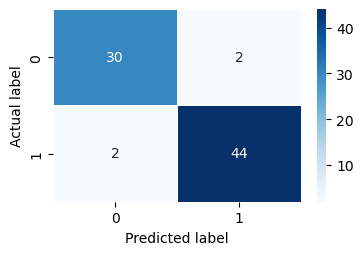

In [24]:
rf_accuracy = []
rf_auroc = []
rf_aucpr = []
rf_sensitivity = []
rf_specificity = []

rf_accuracy_sd = []
rf_auroc_sd = []
rf_aucpr_sd = []
rf_sensitivity_sd = []
rf_specificity_sd = []

for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    
    subset = set_names[index]

    # Model & pipeline
    rf_model = RandomForestClassifier(n_estimators=100, random_state=123)

    rf_pipeline = Pipeline([
        # ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=5)),
        ('classifier', rf_model)
    ])

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

    # Calculate Scores
    # Confusion Matrix
    y_pred_cv = cross_val_predict(rf_pipeline, X, y, cv=k_fold)
    cm_rf = confusion_matrix(y, y_pred_cv)
    cm_rf = cm_rf / splits
    cm_rf = np.round(cm_rf,0)
    cm_rf = cm_rf.astype(int)
    confusion_matrices.append(cm_rf)

    # Accuracy
    cv_scores_accuracy = cross_val_score(rf_pipeline, X, y, cv=k_fold, scoring="accuracy")
    mean_cv_accuracy = cv_scores_accuracy.mean()
    sd_cv_accuracy = cv_scores_accuracy.std()
    rf_accuracy.append(mean_cv_accuracy)
    rf_accuracy_sd.append(sd_cv_accuracy)

    # ROC
    cv_scores_auroc = cross_val_score(rf_pipeline, X, y, cv=k_fold, scoring=auroc_scorer)
    mean_cv_auroc = cv_scores_auroc.mean()
    sd_cv_auroc = cv_scores_auroc.std()
    rf_auroc.append(mean_cv_auroc)
    rf_auroc_sd.append(sd_cv_auroc)

    # AUCPR
    cv_scores_aucpr = cross_val_score(rf_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer)
    mean_cv_aucpr = cv_scores_aucpr.mean()
    sd_cv_aucpr = cv_scores_aucpr.std()
    rf_aucpr.append(mean_cv_aucpr)
    rf_aucpr_sd.append(sd_cv_aucpr)

    # Sensitivy
    cv_scores_sensitivity = cross_val_score(rf_pipeline, X, y, cv=k_fold, scoring="recall")
    mean_cv_sensitivity = cv_scores_sensitivity.mean()
    sd_cv_sensitivity = cv_scores_sensitivity.std()
    rf_sensitivity.append(mean_cv_sensitivity)
    rf_sensitivity_sd.append(sd_cv_sensitivity)

    # Specificity
    cv_scores_specificity = cross_val_score(rf_pipeline, X, y, cv=k_fold, scoring=specificity_scorer)
    mean_cv_specificity = cv_scores_specificity.mean()
    sd_cv_specificity = mean_cv_specificity.std()
    rf_specificity.append(mean_cv_specificity)
    rf_specificity_sd.append(sd_cv_specificity)

    print("\033[1m" + subset + "\033[0m")
    print("Accuracy: \t", "{:.3f}".format(round(mean_cv_accuracy,3)), "(±", "{:.2f}".format(round(sd_cv_accuracy, 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(mean_cv_auroc,3)), "(±", "{:.2f}".format(round(sd_cv_auroc, 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(mean_cv_aucpr,3)), "(±", "{:.2f}".format(round(sd_cv_aucpr, 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(mean_cv_sensitivity,3)), "(±", "{:.2f}".format(round(sd_cv_sensitivity, 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(mean_cv_specificity, 3)), "(±", "{:.2f}".format(round(sd_cv_specificity, 2)), ")")
    print(" ")
    plot_confusion_matrix(cm_rf, "")

## Gradient Boosting Classifier

Restricted Dataset: Demographic + Scoring + Clinical
Accuracy: 	 0.835 (± 0.03 )
ROC: 	 	 0.812 (± 0.03 )
AUCPR: 	 	 0.801 (± 0.03 )
Sensitivy: 	 0.934 (± 0.03 )
Specificity: 	 0.690 (± 0.00 )
 


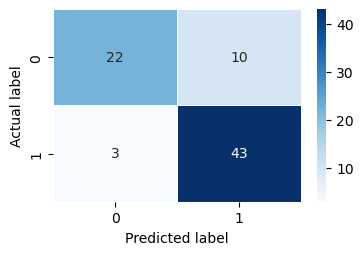

Partially Restricted Dataset: Demographic + Scoring + Clinical + Laboratory
Accuracy: 	 0.733 (± 0.03 )
ROC: 	 	 0.732 (± 0.03 )
AUCPR: 	 	 0.743 (± 0.03 )
Sensitivy: 	 0.749 (± 0.05 )
Specificity: 	 0.714 (± 0.00 )
 


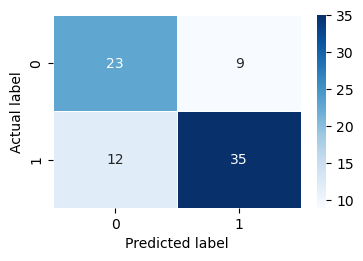

Unrestricted Dataset: Demographic + Scoring + Clinical + Laboratory + Ultrasound
Accuracy: 	 0.936 (± 0.03 )
ROC: 	 	 0.933 (± 0.03 )
AUCPR: 	 	 0.932 (± 0.03 )
Sensitivy: 	 0.943 (± 0.02 )
Specificity: 	 0.924 (± 0.00 )
 


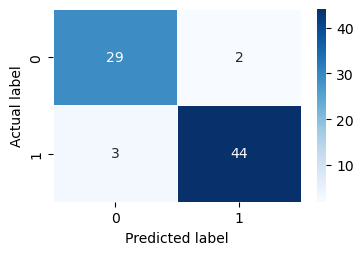

Complete Dataset: all variables
Accuracy: 	 0.947 (± 0.02 )
ROC: 	 	 0.947 (± 0.03 )
AUCPR: 	 	 0.949 (± 0.03 )
Sensitivy: 	 0.942 (± 0.01 )
Specificity: 	 0.952 (± 0.00 )
 


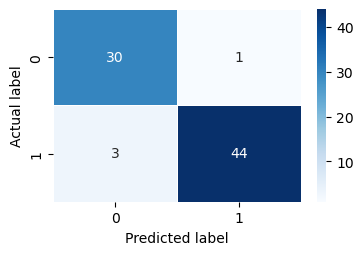

In [26]:
gb_accuracy = []
gb_auroc = []
gb_aucpr = []
gb_sensitivity = []
gb_specificity = []

gb_accuracy_sd = []
gb_auroc_sd = []
gb_aucpr_sd = []
gb_sensitivity_sd = []
gb_specificity_sd = []

for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    
    subset = set_names[index]

    # Model & pipeline
    gbm_model = GradientBoostingClassifier(n_estimators=100, random_state=123)

    gbm_pipeline = Pipeline([
        # ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=5)),
        ('classifier', gbm_model)
    ])

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

    # Calculate Scores
    # Confusion Matrix
    y_pred_cv = cross_val_predict(gbm_pipeline, X, y, cv=k_fold)
    cm_gbm = confusion_matrix(y, y_pred_cv)
    cm_gbm = cm_gbm / splits
    cm_gbm = np.round(cm_gbm,0)
    cm_gbm = cm_gbm.astype(int)
    confusion_matrices.append(cm_gbm)

    # Accuracy
    cv_scores_accuracy = cross_val_score(gbm_pipeline, X, y, cv=k_fold, scoring="accuracy")
    mean_cv_accuracy = cv_scores_accuracy.mean()
    sd_cv_accuracy = cv_scores_accuracy.std()
    gb_accuracy.append(mean_cv_accuracy)
    gb_accuracy_sd.append(sd_cv_accuracy)

    # ROC
    cv_scores_auroc = cross_val_score(gbm_pipeline, X, y, cv=k_fold, scoring=auroc_scorer)
    mean_cv_auroc = cv_scores_auroc.mean()
    sd_cv_auroc = cv_scores_auroc.std()
    gb_auroc.append(mean_cv_auroc)
    gb_auroc_sd.append(sd_cv_auroc)

    # AUCPR
    cv_scores_aucpr = cross_val_score(gbm_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer)
    mean_cv_aucpr = cv_scores_aucpr.mean()
    sd_cv_aucpr = cv_scores_aucpr.std()
    gb_aucpr.append(mean_cv_aucpr)
    gb_aucpr_sd.append(sd_cv_aucpr)

    # Sensitivy
    cv_scores_sensitivity = cross_val_score(gbm_pipeline, X, y, cv=k_fold, scoring="recall")
    mean_cv_sensitivity = cv_scores_sensitivity.mean()
    sd_cv_sensitivity = cv_scores_sensitivity.std()
    gb_sensitivity.append(mean_cv_sensitivity)
    gb_sensitivity_sd.append(sd_cv_sensitivity)

    # Specificity
    cv_scores_specificity = cross_val_score(gbm_pipeline, X, y, cv=k_fold, scoring=specificity_scorer)
    mean_cv_specificity = cv_scores_specificity.mean()
    sd_cv_specificity = mean_cv_specificity.std()
    gb_specificity.append(mean_cv_specificity)
    gb_specificity_sd.append(sd_cv_specificity)

    print("\033[1m" + subset + "\033[0m")
    print("Accuracy: \t", "{:.3f}".format(round(mean_cv_accuracy,3)), "(±", "{:.2f}".format(round(sd_cv_accuracy, 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(mean_cv_auroc,3)), "(±", "{:.2f}".format(round(sd_cv_auroc, 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(mean_cv_aucpr,3)), "(±", "{:.2f}".format(round(sd_cv_aucpr, 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(mean_cv_sensitivity,3)), "(±", "{:.2f}".format(round(sd_cv_sensitivity, 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(mean_cv_specificity, 3)), "(±", "{:.2f}".format(round(sd_cv_specificity, 2)), ")")
    print(" ")
    plot_confusion_matrix(cm_gbm, "")

## Neural Network

In [29]:
nn_accuracy = []
nn_auroc = []
nn_aucpr = []
nn_sensitivity = []
nn_specificity = []

nn_accuracy_sd = []
nn_auroc_sd = []
nn_aucpr_sd = []
nn_sensitivity_sd = []
nn_specificity_sd = []

for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    
    subset = set_names[index]

    # Pipeline
    nn_pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('imputer', KNNImputer(n_neighbors=5))
    ])

    # Using the pipeline for X and creating tensors
    X_nn = nn_pipeline.fit_transform(X)

    X_nn = torch.tensor(X_nn, dtype=torch.float32)
    y_nn = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)

    # Model
    class NeuralNetwork(nn.Module):
        def __init__(self):
            super().__init__()
            self.hidden = nn.Linear(X.shape[1], 128)
            self.relu = nn.ReLU()
            self.layer2 = nn.Linear(128, 64)
            self.act2 = nn.ReLU()
            self.output = nn.Linear(64, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.relu(self.hidden(x))
            x = self.act2(self.layer2(x))
            x = self.sigmoid(self.output(x))
            return x

    def model_train(model, X_train, y_train, X_val, y_val):

        # Loss function (binary cross entropy) and optimizer
        loss_func = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        n_epochs = 50
        batch_size = 10
        batch_start = torch.arange(0, len(X_train), batch_size)

        best_acc = -np.inf
        best_weights = None
        best_sensitivity = 0
        best_specificity = 0
        best_auroc = 0
        best_aucpr = 0

        for epoch in range(n_epochs):
            model.train()
            with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                bar.set_description(f"Epoch {epoch}")
                for start in bar:
                    # take a batch
                    X_batch = X_train[start:start+batch_size]
                    y_batch = y_train[start:start+batch_size]
                    # forward pass
                    y_pred = model(X_batch)
                    loss = loss_func(y_pred, y_batch)
                    # backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    # update weights
                    optimizer.step()
                    # print progress
                    acc = (y_pred.round() == y_batch).float().mean()
                    bar.set_postfix(
                        loss=float(loss),
                        acc=float(acc)
                    )
            # evaluate accuracy, sensitivity, specificity, AUROC, and AUCPR at end of each epoch
            model.eval()
            y_pred = model(X_val)
            acc = (y_pred.round() == y_val).float().mean()
            sensitivity = calculate_sensitivity(y_val, y_pred.round())
            specificity = calculate_specificity(y_val, y_pred.round())
            auroc = auroc_scorer(y_val, y_pred)
            aucpr = aucpr_scorer(y_val, y_pred)

            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
                best_sensitivity = sensitivity
                best_specificity = specificity
                best_auroc = auroc
                best_aucpr = aucpr

        # restore model and return best accuracy, sensitivity, specificity, AUROC, and AUCPR
        model.load_state_dict(best_weights)
        return best_acc, best_auroc, best_aucpr, best_sensitivity, best_specificity

    def calculate_sensitivity(y_true, y_pred):
        true_positive = torch.logical_and(y_true == 1, y_pred == 1).sum().item()
        actual_positive = (y_true == 1).sum().item()
        sensitivity = true_positive / actual_positive if actual_positive != 0 else 0
        return sensitivity

    def calculate_specificity(y_true, y_pred):
        true_negative = torch.logical_and(y_true == 0, y_pred == 0).sum().item()
        actual_negative = (y_true == 0).sum().item()
        specificity = true_negative / actual_negative if actual_negative != 0 else 0
        return specificity

    def auroc_scorer(y_true, y_pred):
        return roc_auc_score(y_true.detach().numpy(), y_pred.detach().numpy())

    def aucpr_scorer(y_true, y_pred):
        return average_precision_score(y_true.detach().numpy(), y_pred.detach().numpy())


    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)
    cv_scores_accuracy = []
    cv_scores_auroc = []
    cv_scores_aucpr = []
    cv_scores_sensitivity = []
    cv_scores_specificity = []

    for train, test in k_fold.split(X_nn, y_nn):
        model = NeuralNetwork()
        results = model_train(model, X_nn[train], y_nn[train], X_nn[test], y_nn[test])
        cv_scores_accuracy.append(results[0])
        cv_scores_auroc.append(results[1])
        cv_scores_aucpr.append(results[2])
        cv_scores_sensitivity.append(results[3])
        cv_scores_specificity.append(results[4])


    nn_accuracy.append(np.mean(cv_scores_accuracy))
    nn_accuracy_sd.append(np.std(cv_scores_accuracy))

    nn_auroc.append(np.mean(cv_scores_auroc))
    nn_auroc_sd.append(np.std(cv_scores_auroc))

    nn_aucpr.append(np.mean(cv_scores_aucpr))
    nn_aucpr_sd.append(np.std(cv_scores_aucpr))

    nn_sensitivity.append(np.mean(cv_scores_sensitivity))
    nn_sensitivity_sd.append(np.std(cv_scores_sensitivity))

    nn_specificity.append(np.mean(cv_scores_specificity))
    nn_specificity_sd.append(np.std(cv_scores_specificity))

    print("\033[1m" + subset + "\033[0m")
    print("Accuracy: \t", "{:.3f}".format(round(np.mean(cv_scores_accuracy),3)), "(±", "{:.2f}".format(round(np.std(cv_scores_accuracy), 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(np.mean(cv_scores_auroc),3)), "(±", "{:.2f}".format(round(np.std(cv_scores_auroc), 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(np.mean(cv_scores_aucpr),3)), "(±", "{:.2f}".format(round(np.std(cv_scores_aucpr), 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(np.mean(cv_scores_sensitivity),3)), "(±", "{:.2f}".format(round(np.std(cv_scores_sensitivity), 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(np.mean(cv_scores_specificity), 3)), "(±", "{:.2f}".format(round(np.std(cv_scores_specificity), 2)), ")")
    print(" ")

Restricted Dataset: Demographic + Scoring + Clinical
Accuracy: 	 0.840 (± 0.03 )
ROC: 	 	 0.892 (± 0.03 )
AUCPR: 	 	 0.915 (± 0.03 )
Sensitivy: 	 0.902 (± 0.04 )
Specificity: 	 0.751 (± 0.03 )
 
Partially Restricted Dataset: Demographic + Scoring + Clinical + Laboratory
Accuracy: 	 0.755 (± 0.02 )
ROC: 	 	 0.804 (± 0.03 )
AUCPR: 	 	 0.869 (± 0.03 )
Sensitivy: 	 0.789 (± 0.05 )
Specificity: 	 0.706 (± 0.06 )
 
Unrestricted Dataset: Demographic + Scoring + Clinical + Laboratory + Ultrasound
Accuracy: 	 0.929 (± 0.02 )
ROC: 	 	 0.965 (± 0.01 )
AUCPR: 	 	 0.978 (± 0.01 )
Sensitivy: 	 0.929 (± 0.02 )
Specificity: 	 0.928 (± 0.05 )
 
Complete Dataset: all variables
Accuracy: 	 0.892 (± 0.02 )
ROC: 	 	 0.953 (± 0.02 )
AUCPR: 	 	 0.971 (± 0.01 )
Sensitivy: 	 0.904 (± 0.05 )
Specificity: 	 0.876 (± 0.05 )
 


## Summary & Model Comparison

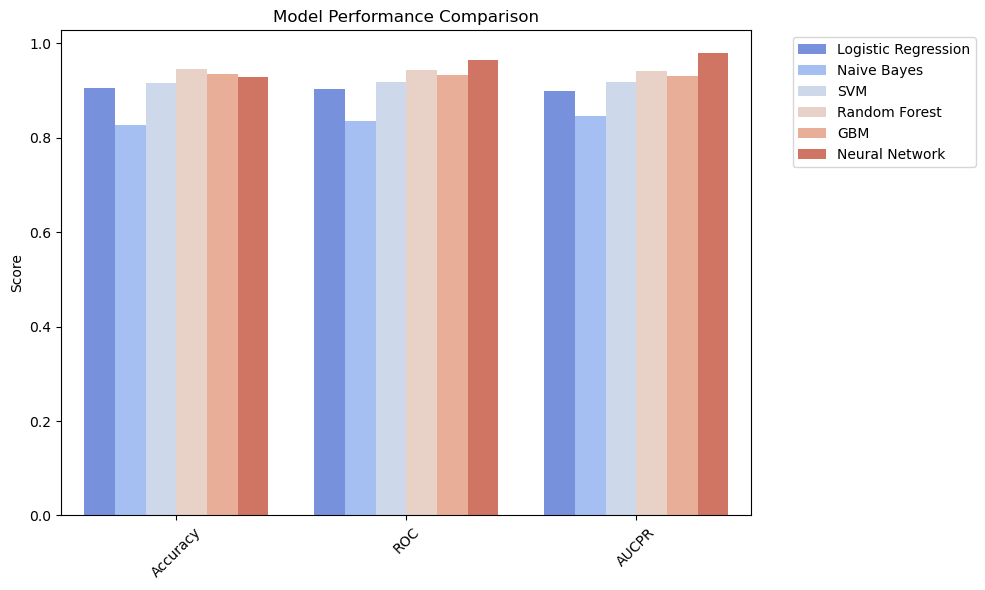

In [14]:
colors = sns.color_palette("coolwarm", len(models))

metrics = ["Accuracy", "ROC", "AUCPR"]
values = [accuracy, auroc, aucpr]

data = {"Model": models}
for metric, metric_values in zip(metrics, values):
    data[metric] = metric_values
metrics_df = pd.DataFrame(data)

metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Metric", y="Value", hue="Model", palette=colors)
plt.title("Model Performance Comparison")
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [31]:
lr_accuracy

[0.8166666666666667,
 0.7410256410256411,
 0.9051282051282051,
 0.8935897435897436]

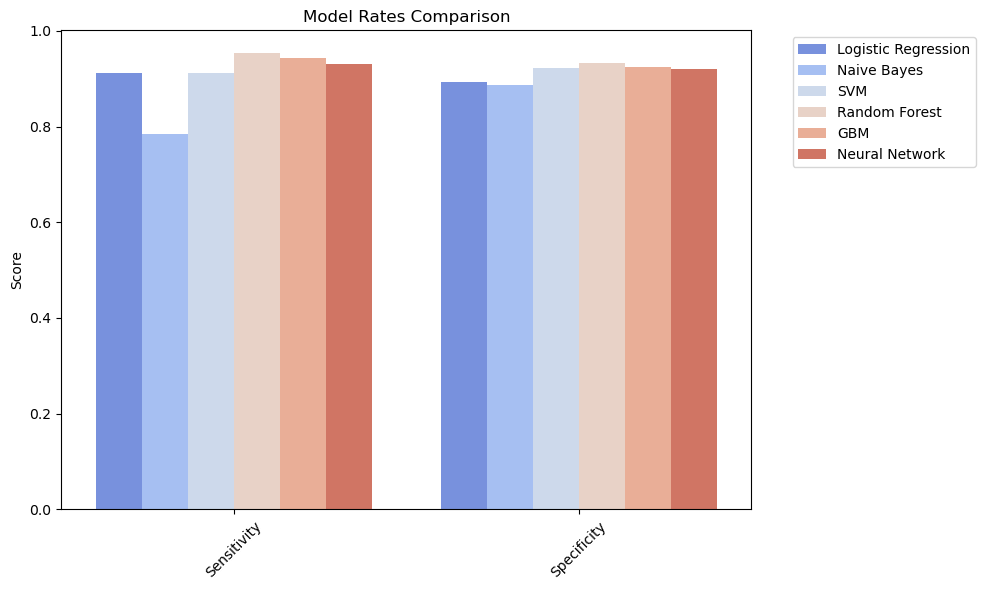

In [15]:
colors = sns.color_palette("coolwarm", len(models))

metrics = ["Sensitivity", "Specificity"]
values = [sensitivity_list, specificity_list]

data = {"Model": models}
for metric, metric_values in zip(metrics, values):
    data[metric] = metric_values
metrics_df = pd.DataFrame(data)

metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Metric", y="Value", hue="Model", palette=colors)
plt.title("Model Rates Comparison")
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()